# VAR GLLVM

 ## Model Specification

Let  $y_{i1t},y_{i2t},\ldots,y_{ipt}$  be a set of $p$ response or observed variables at time $t,\ t=1,\ldots,T$ for  individual $i,\ i=1,\ldots,n$. Let $\mathbf{x}_{it}$ be a set of observed $k$-dimensional covariates at time $t,\ t=1,\ldots,T$.

Models for multivariate longitudinal data have to account for the three sources of variability
present in the data, that is (i) cross-sectional associations between the responses at a particular time point, (ii) cross-lagged
associations between different responses at different occasions, and  (iii) the association between repeated measures of the same response
over time. The first source of variability is accounted for
a time-dependent latent variable $z_{i1}, z_{i2},\ldots,z_{iT}$. Modeling the temporal evolution of the latent variable acpoisson for the cross-lagged associations between different responses over time.
The third source of variability can be accounted for a set of item-specific random effects $\mathbf{u}_{i}=(u_{i1}, \ldots, u_{ip})'$.

According to the GLLVM framework we have

\begin{align*}
   \nonumber y_{ijt}|\mu_{ijt} &\sim \mathcal{F}_j(y_{ijt}\vert \mu_{ijt}, \tau_j)\\
   \mu_{ijt}&=  g_j(\eta_{ijt})=g_j(\beta_{0jt} + \mathbf{x}_{i}^{\top}\boldsymbol \beta_{jt} + z_{it}^{\top}\lambda_{jt}+u_{ij}\sigma_{u_j})\\ %  \label{eqn:GLLVM-model2}
\end{align*}
where $g_j(\cdot),j=1,\ldots,p$ is a known {\it link function}, $\eta_{ijt}=\beta_{0jt} + \mathbf{x}_{i}^{\top}\boldsymbol \beta_{jt} + z_{it}^{\top}\lambda_{jt}+u_{ij},i=1,\ldots,n,j=1,\ldots,p, t=1,\ldots,T$ is the {\it linear predictor},  and $\mathcal{F}_j(y_{ijt}\vert \eta_{ijt}, \tau_j)$ denotes a distribution from the exponential family with mean $\mu_{ijt}$ and response variable-specific dispersion parameter $\tau_j$. \vspace{5pt}\\
The dynamics of the latent variable over time is modelled through a stationary vector-autoregressive model of first order


$$
z_{i,t} = Az_{i,t-1} +  \epsilon_{i,t}\\
||A||_2 < 1\\
\epsilon_{i,t} \sim N(0, I)\\
$$

initialization for $t=0$:

$$
z_{i, 1} \sim N(0, \Sigma_{z1})\\
\Sigma_{z1} = 
\begin{pmatrix}
    \sigma_{z1,1}^2&\\
    &\sigma_{z1,2}^2
\end{pmatrix}\\
\sigma_{z1,i}>0 \forall i
$$

Moreover, we assume the random effects independent of the latent variable and their common distribution $\mathbf{u}_{i}\sim N_p(\mathbf{0}, \boldsymbol I)$.


### Estimating $\epsilon, u$
To estimate $z, u$, we use a neural network. The neural network learns to estimate linpar from condmu. Once linpar is estimated, using the parameters of the model we can get back to the shocks (of known distributions). The training of the neural network is guided by the knowledge of the parameters. In essence, the neural network learns to  estimate the linear parameter from the responses (or transformation thereof), which is an easy task. Once the linear parameter is known, we obtain the Z as coefficients for lambda and u_scaled as reminders. (since the goal is to estimate z and u given the parameter values, we can use them). Once we have z, we can get epsilon. We then rescale all variables using the known parameters so all epsilon and u are N(0,I), and thus directly comparable on precisely the same scale. We then use MSE on all these together to train the neural network. Even though it is a multi-objective, we know their weights. This provides speedups of several orders of magnitudes, compared to computing the solution directly.

### Imputatin of Missig Completely at Random data:
To estimate the model with missing completely at random data (MCAR), we iteratively impute the observed and simulated samples with the conditional mean of the data.



# TODO:
* test that the operations in forward are correct
* in the forward fct of the encoder, test that the gradients of the model used as argument are NOT CHANGED
* Implement conditional Imputation

In [1]:
import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_value_
import numpy as np
from VAR1 import VAR1
from typing import Type, Optional, Tuple
import matplotlib.pyplot as plt
import VARGLLVM


## Training Loops

In [2]:
batch_size = 100
num_var = 10
num_latent = 2
num_covar = 3
seq_length = 10
prob_mis = 0.4
x = torch.randn((batch_size, seq_length, num_covar))

response_types = {
    'bernoulli': np.arange(5),
    'poisson': np.arange(5, num_var)
}

model = VARGLLVM.VARGLLVM(num_var = num_var,
                 num_latent = num_latent,
                 num_covar = num_covar,
                 response_types = response_types,
                 add_intercepts=False)

encoder = VARGLLVM.Encoder(num_var, num_covar, num_latent, num_hidden=10)

# Some data modification to check if we actually learn anything hehe
with torch.no_grad():
    model.A[:] = torch.Tensor([[0.8, 0.2], [0.1, 0.6]]) # include some amount of auto-correlation
    model.logvar_u[:] = torch.ones_like(model.logvar_u)
    data_true = model.sample(batch_size, seq_length=seq_length, x=x)
    # Revert
    model.A[:] = torch.Tensor([[0, 0], [0, 0]]) # revert and try to learn it
    model.logvar_u[:] = torch.zeros_like(model.logvar_u)

    mask = torch.rand_like(data_true['y']) < 0.2
    y_nomis = data_true['y'].clone()

In [3]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the models to device
# Move the models and data to device
encoder = encoder.to(device)
model = model.to(device)
data_true = {key:value.to(device) for key, value in data_true.items()} # Moving data to the device



In [4]:

# Define optimizer and criterion as before
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.01)
encoder_criterion = nn.MSELoss()

model_optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
model_criterion = VARGLLVM.MELoss()

# Define schedulers
encoder_scheduler = torch.optim.lr_scheduler.StepLR(encoder_optimizer, step_size=50, gamma=0.8)
model_scheduler = torch.optim.lr_scheduler.StepLR(model_optimizer, step_size=50, gamma=0.8)


In [5]:
data_true['y'] = VARGLLVM.impute_values(model, encoder, data_true['y'], mask, data_true['x'], impute_with=0.5)

for i in range(500):
    with torch.no_grad():
        data_true['y'] = VARGLLVM.impute_values(model, encoder, data_true['y'], mask, data_true['x'])
        
    encoder_loss = VARGLLVM.train_encoder(
        encoder, 
        model, 
        encoder_criterion, 
        encoder_optimizer, 
        num_epochs=10, 
        sample=True,
        batch_size=x.shape[0],
        seq_length=x.shape[1],
        x=x,
        data=None,
        verbose=False,
        mask=mask, 
        impute_with=0.5)
    
    encoder_scheduler.step()  # Step the encoder scheduler
    
    decoder_loss = VARGLLVM.train_decoder(
        model, 
        encoder, 
        model_criterion, 
        model_optimizer, 
        data_true,
        num_epochs=1, 
        transform=True,
        verbose=False,
        mask = mask,
        impute_with=0.5)
    
    model_scheduler.step()  # Step the model scheduler

    print(f'Iteration {i}: {model.A.flatten()}')


Iteration 0: tensor([ 0.0050, -0.0050, -0.0050,  0.0050], grad_fn=<ReshapeAliasBackward0>)
Iteration 1: tensor([ 0.0100, -0.0100, -0.0100,  0.0100], grad_fn=<ReshapeAliasBackward0>)
Iteration 2: tensor([ 0.0150, -0.0150, -0.0050,  0.0150], grad_fn=<ReshapeAliasBackward0>)
Iteration 3: tensor([ 0.0200, -0.0200, -0.0100,  0.0200], grad_fn=<ReshapeAliasBackward0>)
Iteration 4: tensor([ 0.0250, -0.0250, -0.0150,  0.0250], grad_fn=<ReshapeAliasBackward0>)
Iteration 5: tensor([ 0.0300, -0.0300, -0.0200,  0.0300], grad_fn=<ReshapeAliasBackward0>)
Iteration 6: tensor([ 0.0350, -0.0350, -0.0250,  0.0350], grad_fn=<ReshapeAliasBackward0>)
Iteration 7: tensor([ 0.0400, -0.0400, -0.0300,  0.0400], grad_fn=<ReshapeAliasBackward0>)
Iteration 8: tensor([ 0.0450, -0.0450, -0.0250,  0.0450], grad_fn=<ReshapeAliasBackward0>)
Iteration 9: tensor([ 0.0500, -0.0500, -0.0300,  0.0500], grad_fn=<ReshapeAliasBackward0>)
Iteration 10: tensor([ 0.0550, -0.0550, -0.0250,  0.0550], grad_fn=<ReshapeAliasBackward0>

In [6]:
encoded = encoder(y=model.transform_responses(data_true['y']), VARGLLVM_model=model, x=data_true['x'])

In [7]:
_, decoded_mean = model(data_true['epsilon'], data_true['u'], data_true['x'])

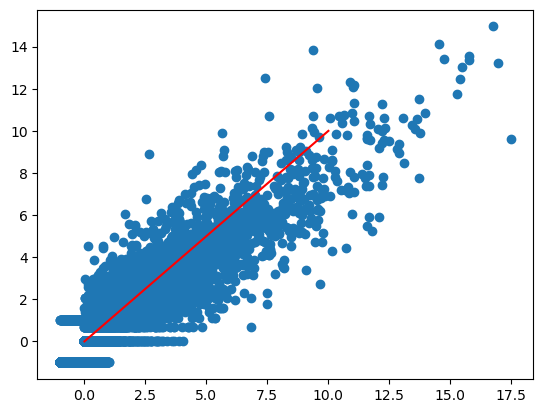

In [8]:
plt.scatter(model.transform_responses(decoded_mean).detach().numpy(), model.transform_responses(y_nomis).detach().numpy())
plt.plot([0,10],[0,10], color="red")

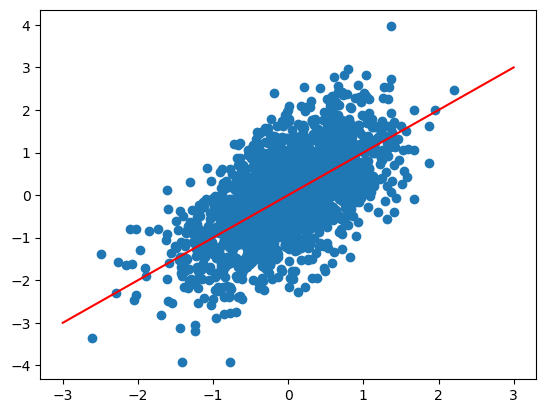

In [9]:
plt.scatter(encoded[0].detach(), data_true['epsilon'].detach())
plt.plot([-3,3], [-3,3], color="red")

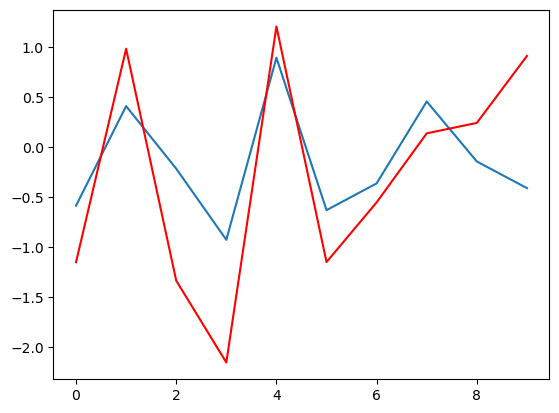

In [10]:
plt.plot(encoded[0][0,:,0].detach())
plt.plot(data_true['epsilon'][0,:,0].detach(), color="red")

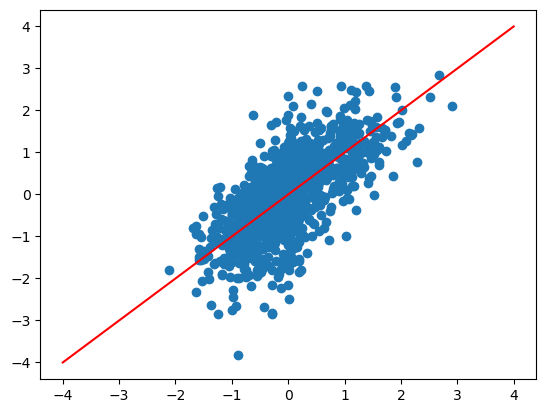

In [11]:
plt.scatter(encoded[1].detach(), data_true['u'].detach())
plt.plot([-4,4], [-4,4], color="red")